>### Object Detection

In [2]:
import os
import numpy as np
import pandas as pd
import pickle
import glob

# Plotting
import imageio
import PIL
from PIL import ImageDraw, Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

# Framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms
import torch.nn.functional as F

In [2]:
import tensorflow_hub as hub
from PIL import Image, ImageFont, ImageColor, ImageOps #这个只能import，否则PIL.ImageFont不行
import tempfile
from six.moves.urllib.request import urlopen
import io

#### Data

In [54]:
# 网上下载图片，保存到本地jpg
def download_image(url, width=None, height=None):
    _, filepath = tempfile.mkstemp(suffix=".jpg") #创建临时文件，指定后缀，文件名随机，返回(数字，文件path)
    response = urlopen(url) #打开图片的http url
    image = response.read() #读取图片
    buffer = io.BytesIO(image) #保存到缓存 six.BytesIO, io.BytesIO
    pil_image = Image.open(buffer) #打开图片
    
    if (width and height): #需要resize时，否则返回原图尺寸
        pil_image = ImageOps.fit(pil_image, (width, height), Image.ANTIALIAS) #resize，同时如果新尺寸比例和原图不一致会crop
        #pil_image = pil_image.resize((width, height)) #resize，比例改变可能会变形
    pil_image = pil_image.convert("RGB") #以防万一确保是RGB
    
    pil_image.save(filepath, format="JPEG", quality=90) #保存到临时文件
    print(f'Image has been downloaded to {filepath}')
    plt.imshow(pil_image)
    return filepath, pil_image

# 本地图片转成tensor
def image_to_tensor(path):
    image = tf.io.read_file(path) #从路径读取图片
    image = tf.image.decode_jpeg(image, channels=3) #从jpeg转成tensor
    return image

Modify notebookapp.py config to avoid exceeding IOPub data rate: `ServerApp.iopub_data_rate_limit=1.0e10`

Image has been downloaded to /var/folders/sd/6d0w7lz121v38498dngh6y540000gn/T/tmpiy_po9un.jpg
(856, 1280, 3)


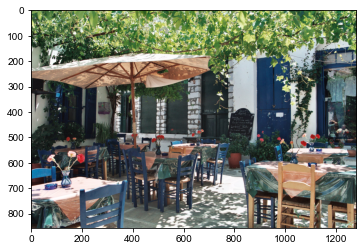

In [42]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"
filepath, image = download_image(image_url, 1280, 856)
image = image_to_tensor(filepath)
print(image.shape)

#### Model
* [ssd + mobilenet V2](https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2) small and fast.
* [FasterRCNN + InceptionResNet V2](https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1): high accuracy

In [43]:
MODULE_HANDLE = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
model = hub.load(MODULE_HANDLE) #加载模型

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


For object detection models, 'default' signature will accept a batch of image tensors and output a dictionary describing the objects detected.

In [28]:
# 模型的可选signatures，这里只有默认一种
model
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x7F22BBEBFB50>}))

In [26]:
#用来检测的wrapped function，部分情况下可以直接用model，但这里不行
detector = model.signatures['default'] 
detector

<ConcreteFunction pruned(images) at 0x7F22BBEBFB50>

In [118]:
# 只有取到detector情况下才能看到
print(len(detector.inputs))
print(detector.inputs[0])
print(len(detector.outputs))
print(detector.outputs[0])
print(detector.graph)
print(len(detector.trainable_variables)) 
print(len(detector.variables))

1
Tensor("hub_input/image_tensor:0", shape=(1, None, None, 3), dtype=float32)
5
Tensor("hub_input/strided_slice:0", shape=(None, 4), dtype=float32)
FuncGraph(name=pruned, id=139713951806992)
0
0


#### Prediction

In [120]:
#detector需要tensor，本模型要求float同时normalize[0,1]
converted_image  = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]  
y_pred = detector(converted_image) #输出字典，包括检测到的objects分数、label和bboxes
y_pred = {key:value.numpy() for key,value in y_pred.items()} #把tensor转为numpy数组
y_pred.keys()

dict_keys(['detection_class_labels', 'detection_class_entities', 'detection_class_names', 'detection_scores', 'detection_boxes'])

In [122]:
#预测结构都是列表{'key':array}，查看每张图片会得到的值shape，注意不同模型结果的格式shape可能不同
print(f'There are {len(y_pred.keys())} outputs, and can predict {len(y_pred["detection_scores"])} objects.')
for i in sorted(y_pred.keys()):
    print(f'{i}: {y_pred[i].shape}')

There are 5 outputs, and can predict 100 objects.
detection_boxes: (100, 4)
detection_class_entities: (100,)
detection_class_labels: (100,)
detection_class_names: (100,)
detection_scores: (100,)


In [124]:
print(y_pred["detection_scores"][:5]) #每一个object的分数
print(y_pred["detection_class_entities"][:5]) #text label,可以decode("ascii")
print(y_pred["detection_class_labels"][:5]) #数字 label
print(y_pred["detection_class_names"][:5]) 
print(y_pred["detection_boxes"][:5])  #(ymin, xmin, ymax, xmax)

[0.83664495 0.6220043  0.5904807  0.5817069  0.5636521 ]
[b'House' b'Person' b'Tree' b'Person' b'Tree']
[241  69 391  69 391]
[b'/m/03jm5' b'/m/01g317' b'/m/07j7r' b'/m/01g317' b'/m/07j7r']
[[0.0683918  0.5146615  0.61296386 0.99290454]
 [0.7869997  0.8939478  0.989622   0.9473819 ]
 [0.251586   0.8167684  0.5732511  0.99746186]
 [0.7449764  0.8193666  0.97401124 0.89456123]
 [0.22683442 0.53372675 0.5247213  0.6266677 ]]


In [ ]:
#如果有检测到关节keypoints，还会有
print(y_pred['detection_keypoints'][:5])
print(y_pred['detection_keypoints_scores'][:5])
COCO17_HUMAN_POSE_KEYPOINTS= [(0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6),
    (5, 7), (7, 9), (6, 8), (8, 10), (5, 6), (5, 11), (6, 12), (11, 12),
    (11, 13), (13, 15), (12, 14), (14, 16)]

#### Visualize

In [71]:
def draw_bbox_text_on_image(image, xmin, ymin, xmax, ymax, color, font, 
                            texts, thickness, normalized_coordinates):
    draw = ImageDraw.Draw(image) #在原图上画
    
    # bbox
    if normalized_coordinates: #相对位置
        width, height = image.size
        (x1, y1, x2, y2) = (xmin*width, ymin*height, xmax*width, ymax*height)
    else:
        (x1, y1, x2, y2) = (xmin, ymin, xmax, ymax)
    draw.line([(x1, y1), (x1, y2), (x2, y2), (x2, y1), (x1, y1)],
              width=thickness, fill=color) #从左上开始逆时针画
    
    # text
    text_height = [font.getsize(text)[1] for text in texts] #每行字符串占位pixel (w,h) 
    text_height = (1 + 2 * 0.05) * sum(text_height) #每行文字上下留margin
    if y1 > text_height: 
        text_bottom = y1 #如果bbox上方margin足够放文字，放框上方
    else:
        text_bottom = y1+text_height #否则放bbox下方
        
    for text in texts[::-1]: #倒序从最后一行开始输出
        text_width, text_height = font.getsize(text)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(x1, text_bottom - text_height - 2*margin), #文字实色框
                        (x1 + text_width, text_bottom)], fill=color)
        draw.text((x1 + margin, text_bottom - text_height - margin), #以文字左上坐标开始写字
                  text, fill="black", font=font)
        text_bottom -= text_height - 2 * margin #文字低端逐渐往上调整，实现多行文字    
    return image


def draw_bboxes_texts_on_image(image, boxes, classes, scores, score_threshold, n_boxes, thickness, normalized_coordinates):
    #原图是jpg转为numpy的三通道图，可以直接画
    pil_image = Image.fromarray(image).convert('RGB') 

    #设置字体颜色
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",25)
    except IOError:
        font = ImageFont.load_default()
    colors = list(ImageColor.colormap.values()) #148种颜色名称和代码字典，足够100 classes使用
    
    #最多遍历10个boxes
    for i in range(min(boxes.shape[0], n_boxes)): 
        if scores[i] > score_threshold: #除去低分的bbox
            ymin, xmin, ymax, xmax = boxes[i]
            text = f'{classes[i].decode("ascii")}: {int(scores[i]*100)}%'
            texts = [text] #预备给多行文字输出，从第一行开始的顺序列表
            color = colors[hash(classes[i]) % len(colors)] #确保每个class对应一种颜色，颜色分配随意，利用hash得到索引在颜色数量范围内
            draw_bbox_text_on_image(pil_image, xmin, ymin, xmax, ymax, colors[i], font, texts,
                           thickness, normalized_coordinates) #在新图层上画框      
            np.copyto(image, np.array(pil_image)) #把pil的值复制过去，虽然不知道为什么直接改
    return image


def object_detection(image, detector, score_threshold=0.6, n_boxes=10, thickness=4, normalized_coordinates=True):
    converted_image  = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...] 
    y_pred = detector(converted_image) #输出字典，包括检测到的objects分数、label和bboxes
    y_pred = {key:value.numpy() for key,value in y_pred.items()} 
    
    image = image.numpy().astype('uint8') #画图需要先转tensor为uint8的numpy数组
    boxes = y_pred['detection_boxes']
    classes = y_pred['detection_class_entities']
    scores = y_pred['detection_scores']
    n_objects = np.sum(scores>score_threshold)
    print(f'Found {n_objects} objects.')
    
    # 画图
    plt.figure(figsize=(10,8))
    img_with_bboxes = draw_bboxes_texts_on_image(image, boxes, classes, scores, score_threshold, 
                                                 n_boxes, thickness, normalized_coordinates)
    plt.imshow(img_with_bboxes)
    plt.axis('off')

Image has been downloaded to /tmp/tmps13fy_z1.jpg


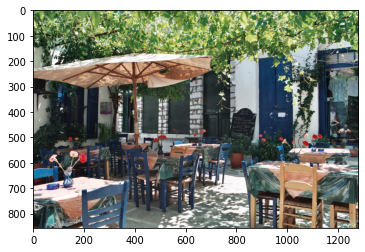

In [48]:
# 更多尝试
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"
filepath, image = download_image(image_url, 1280, 856)
image = image_to_tensor(filepath)

Found 7 objects.


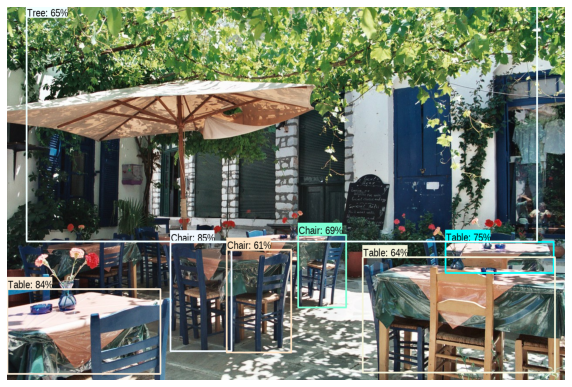

In [37]:
object_detection(image,detector)

In [ ]:
#若有安装object detection API的viz_utils (参考下面模块)
label_id_offset=1 #传统上mapping非背景object从1开始，若有背景则为0
category_index = {97:{'id':97, 'name':'Chair'},281:{'id':281, 'name':'Table'},
                  391:{'id':391, 'name':'Tree'}} #这种格式的
def object_detection_api(image, detector):
    converted_image  = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...] 
    y_pred = detector(converted_image) #输出字典，包括检测到的objects分数、label和bboxes
    y_pred = {key:value.numpy() for key,value in y_pred.items()} 
    
    image = image.numpy().astype('uint8') #画图需要先转tensor为uint8的numpy数组
    boxes = y_pred['detection_boxes']
    labels = (y_pred['detection_class_labels'] + label_id_offset).astype(int)
    scores = y_pred['detection_scores']
    #keypoints = y_pred['detection_keypoints']
    #keypoint_scores = y_pred['detection_keypoints_scores']
    
    # 画图
    plt.figure(figsize=(12,8))
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image, boxes, labels, scores, category_index, min_score_thresh=.30,
        use_normalized_coordinates=True, max_boxes_to_draw=20, agnostic_mode=False,
        #keypoints=keypoints, keypoint_scores=keypoint_scores,
        #keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)   
    )
    plt.imshow(image)
    plt.axis('off')

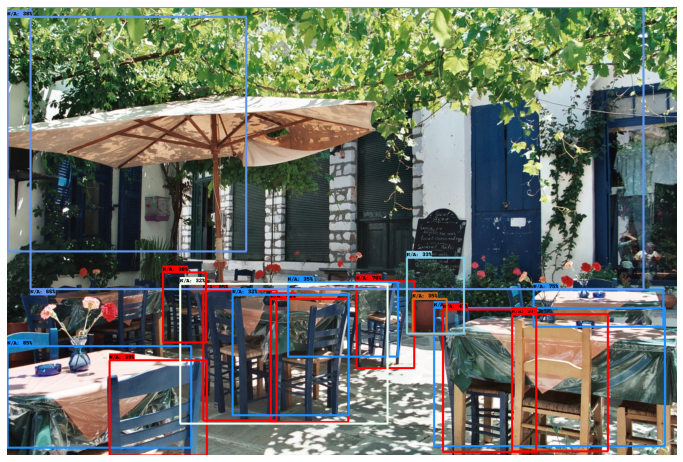

In [60]:
object_detection_api(image, detector)